In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelEncoder

In [3]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")

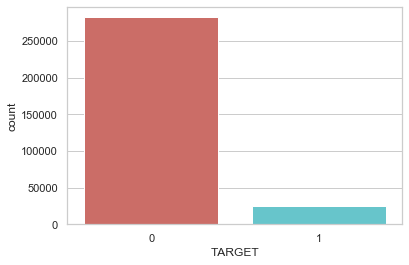

In [9]:
train.TARGET.value_counts()
sns.countplot(x='TARGET', data= train, palette='hls')

In [15]:
count_loan_repaid = len(train[train['TARGET']==0])
count_loan_no_repaid = len(train[train['TARGET']==1])
pct_of_loan_repaid = count_loan_repaid/(count_loan_no_repaid+count_loan_repaid)
print("The loan was repaid in the percentage of ", round(pct_of_loan_repaid*100, 2), '%')
pct_of_loan_no_repaid = count_loan_no_repaid/(count_loan_no_repaid+count_loan_repaid)
print("The loan was not repaid in the percentage of ", round(pct_of_loan_no_repaid*100,2), '%')

The loan was repaid in the percentage of  91.93 %
The loan was not repaid in the percentage of  8.07 %


The plot above shows the we are delaing with an imbalanced class problem, in particular the ratio of repaid-loans to no-repaid-loan is 92:8.